# Music Feature Training Notebook

## Imports

In [1]:
import pandas as pd
import numpy as np

import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

load_dotenv()

DATA_PATH = Path(os.getenv("DATA_PATH"))

# only for .ipynb because relative imports don't work
root_path = (DATA_PATH.parent) 
os.chdir(str(root_path))
 
import src.training.plotting as p
import src.training.postprocessing as pp
import src.training.pre_training as t

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Preprocessing

## Load Data

In [2]:
df = t.get_music_df()

# df2 = t.get_lyric_df()
# df = df1.join(df2, on='song_id')
# df = df1.merge(df2, 'ts.song_id')

## Split data (X,y)
Split data into sample values and sample classes

In [3]:
X = df.values[:, :15]
y = df["popularity"].apply(t.encode_popularity)

# X = df[["explict", "danceability", "energy", "loadness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]]
# X = df[["danceability", "energy", "loadness"]]

## Over-/Undersampling

In [4]:
# sampled and encoded popularity
X, y = RandomUnderSampler(random_state=42).fit_resample(X, y)

## PCA

In [5]:
# Dimensionality Reduction
reduce_to = 15

# PCA feature selection (TODO what does this do?)
cols = pd.DataFrame(X).columns

# Standardization of X
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# apply PCA to X
pca = PCA(n_components=reduce_to)
pca.fit(X, y)
X = pca.transform(X)

print("Amount explained:", sum(pca.explained_variance_ratio_))
print("Amount explained in each PC:", pca.explained_variance_ratio_)

descr = ["PC-" + str(x) for x in range(1, reduce_to + 1)]
print(pd.DataFrame(pca.components_, columns=cols, index=descr))

Amount explained: 1.0
Amount explained in each PC: [0.17174525 0.1236077  0.08762937 0.0784639  0.07533546 0.06928971
 0.06548365 0.06183017 0.05993097 0.0532027  0.0487471  0.03715936
 0.02962022 0.02671915 0.0112353 ]
             0         1         2         3         4         5         6   \
PC-1   0.066951 -0.142523  0.016182 -0.136322 -0.540403 -0.051789 -0.502772   
PC-2  -0.316209  0.370659  0.250687  0.511615 -0.230303  0.065664 -0.133010   
PC-3   0.000946  0.466824  0.250756 -0.308147 -0.011636  0.028628 -0.023916   
PC-4   0.408596 -0.002322 -0.097186  0.169931 -0.019876  0.416773 -0.176336   
PC-5   0.434070  0.268508 -0.574625  0.009237 -0.071881 -0.113611  0.020078   
PC-6  -0.194087 -0.146877 -0.139770 -0.138351 -0.036911  0.666145  0.088987   
PC-7   0.117344  0.129340 -0.383180  0.068245 -0.033486 -0.006737 -0.056369   
PC-8  -0.088887 -0.072109 -0.022023  0.158410  0.043683 -0.150780 -0.210180   
PC-9   0.090792  0.020391  0.171731  0.136914  0.038521 -0.370761  0.

## Feature Selection

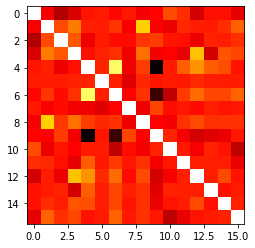

In [6]:
# Pearson Correlation Coefficient
pear_corr = df.corr(method='pearson')
plt.imshow(pear_corr, cmap='hot')
plt.show()

In [7]:
# TODO copy this to plotting notebook, plot only after PCA/feature selection here
# TODO use correct X, y values
# X_1, y_1 = RandomUnderSampler(random_state=42).fit_resample(df, y)

# # Scale features
# max_db = X_1['loadness'].max()
# min_db = X_1['loadness'].min()
# X_1['loadness'] = X_1['loadness'].apply(lambda x: abs(x/40))

# # Drop features with range outside [0, 1]
# X_1 = pd.DataFrame(X_1).drop(['key', 'time_signature', 'release_year', 'duration_ms', 'tempo'], axis=1)

# fig = plt.figure(figsize = (20, 25))
# j = 0
# for i in pd.DataFrame(X_1).columns:
#     plt.subplot(6, 4, j+1)
#     j += 1

#     sns.kdeplot(pd.DataFrame(X_1).query("popularity == 0")[i], color='b', label='pop=0')
#     sns.kdeplot(pd.DataFrame(X_1).query("popularity == 1")[i], color='#000000', label='pop=1')
#     sns.kdeplot(pd.DataFrame(X_1).query("popularity == 2")[i], color='#ff5959', label='pop=2')
#     sns.kdeplot(pd.DataFrame(X_1).query("popularity == 3")[i], color='#fffd86', label='pop=3')
#     sns.kdeplot(pd.DataFrame(X_1).query("popularity == 4")[i], color='#a7e81c', label='pop=4')
#     sns.kdeplot(pd.DataFrame(X_1).query("popularity == 5")[i], color='#65bf65', label='pop=5')
#     plt.legend(loc='best')
#     plt.ylim(0, 17)
#     plt.xlim(0, 1)

# fig.suptitle('Density Analysis')
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# plt.show()

## Train/Test-Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(4868, 15)
(1218, 15)


# Classification

In [9]:
# store classifiers for later plotting
clf_list = []

## Gaussian Naive Bayes

In [10]:
gaussian_clf = GaussianNB()

# fit the model
gaussian_clf.fit(X_train, y_train)
clf_list.append(gaussian_clf)

pp.print_metrics(gaussian_clf, X_test, y_test)

Weighted accuracy: 0.6232
Weighted f1: 0.609
Weighted recall: 0.6232
Weighted precision: 0.653
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


## SVM

In [11]:
# svc_clf = SVC()

# # fit the model
# svc_clf.fit(X_train, y_train)
# clf_list.append(svc_clf)

# pp.print_metrics(svc_clf, X_test, y_test)

## Neural Network

In [12]:
nn_clf = MLPClassifier()

# fit the model
nn_clf.fit(X_train, y_train)
clf_list.append(nn_clf)

pp.print_metrics(nn_clf, X_test, y_test)

Weighted accuracy: 0.6741
Weighted f1: 0.674
Weighted recall: 0.6741
Weighted precision: 0.6756
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


f:\SmartGit-Repositories\song-popularity\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## K-Neighbours Classifier

In [13]:
knn_clf = KNeighborsClassifier()

# fit the model
knn_clf.fit(X_train, y_train)
clf_list.append(knn_clf)

pp.print_metrics(knn_clf, X_test, y_test)

Weighted accuracy: 0.6363
Weighted f1: 0.6356
Weighted recall: 0.6363
Weighted precision: 0.6397
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


## Decision Trees

In [14]:
dt_clf = DecisionTreeClassifier()

# fit the model
dt_clf.fit(X_train, y_train)
clf_list.append(dt_clf)

pp.print_metrics(dt_clf, X_test, y_test)

Weighted accuracy: 0.5509
Weighted f1: 0.5509
Weighted recall: 0.5509
Weighted precision: 0.5518
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


## Random Forest

In [15]:
# use different number of trees in forest 
forest_size = [10,50,100,250,500,1000]

# set seed for random state to get compareable results in every execution (forest randomness)
np.random.seed(500)

for trees in forest_size:
    # set forest size
    print("Predicting with forest size " + str(trees))
    rf = RandomForestClassifier(n_estimators=trees)

    # fit the model
    rf.fit(X_train, y_train)
    clf_list.append(rf)

    pp.print_metrics(rf, X_test, y_test)
    print("--------\n")

Predicting with forest size 10
Weighted accuracy: 0.5895
Weighted f1: 0.5861
Weighted recall: 0.5895
Weighted precision: 0.5898
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}
--------

Predicting with forest size 50
Weighted accuracy: 0.656
Weighted f1: 0.656
Weighted recall: 0.656
Weighted precision: 0.657
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}
--------

Predicting with forest size 100
Weighted accuracy: 0.6617
Weighted f1: 0.6614
Weighted recall: 0.6617
Weighted precision: 0.6643
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}
--------

Predicting with forest size 250
Weighted accuracy: 0.6617
Weighted f1: 0.6609
Weighted recall: 0.6617
Weighted precision: 0.6659
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}
--------

Predicting with forest size 500
Weighted accuracy: 0.6461
Weighted f1: 0.6453
Weighted recall: 0.6461
Weighted precision: 0.65
Contained classes in predic

## Ensemble

In [23]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier

# ens_clf = VotingClassifier(estimators=[
#     ('gauss', GaussianNB()), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier())
# ])

ens_clf = AdaBoostClassifier(base_estimator=GaussianNB(), 
    n_estimators=25, random_state=42)

ens_clf.fit(X_train, y_train)

pp.print_metrics(ens_clf, X_test, y_test)

Weighted accuracy: 0.5493
Weighted f1: 0.5493
Weighted recall: 0.5493
Weighted precision: 0.5495
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


# Model Evaluation

## Store models to .mdl file

In [ ]:
# pp.store_model_to_file(rf, "rf_size=1000_prec=41", "music")

## Metrics + Confusion Matrices

In [ ]:
 # generate list of plots for each clf: metrics, cf_matrix, cf_matrix_norm
 p_list = p.generate_model_plots(X_test, y_test, clf_list)

## Save/display plots

In [ ]:
# params
save_plots = False
n_cols = 3
document_title = "Random Forest up to 2000 trees"
document_folder = "all" # lyrics, model, artist, all

# save/display plots as jpg
p.plots_from_list(document_title, p_list, document_folder, cols=n_cols, save=save_plots)

## Confusion Matrix for Single Classifier

In [ ]:
# assign single classifier
cf_clf = None
normalized = "true" # "true", "all" or None

# Confusion matrix
fig, cax = plt.subplots(figsize=(16, 16)) # subplot for larger size
cax.set_title(str(cf_clf), fontsize=15)
plot_confusion_matrix(estimator=cf_clf, X=X_test, y_true=y_test, cmap=plt.cm.Blues,normalize=normalized,values_format=".2f",ax=cax)

plt.show()

## Scatter Plot

In [ ]:
# Params
sct_title = "Title"
sct_x = None
sct_xlabel = "x-label"
sct_y = None
sct_ylabel = "y-label"

# show scatter plot
plt.title(sct_title)
plt.xlabel(sct_x)
plt.ylabel(sct_y)
plt.scatter(sct_x, sct_y, s=5, alpha=0.5)
plt.show()

# add scatter plot to plot list
p_list.append((plt.scatter, {"x": sct_x, "y": sct_y, "s": 5, "alpha": 0.5}, sct_title, sct_xlabel, sct_ylabel))

## Bar Plot

In [ ]:
# Params
bar_title = "Title"
bar_x = None
bar_xlabel = "x-label"
bar_height = None
bar_ylabel = "y-label"

# show bar plot
plt.title(sct_title)
plt.xlabel(sct_x)
plt.ylabel(sct_y)
plt.bar(sct_x, sct_y)
plt.show()

# add bar plot to plot list
p_list.append((plt.bar, {"x": bar_x, "height": bar_height}, bar_title, bar_xlabel, bar_ylabel))

In [ ]:
# import src.training.postprocessing as pp

# dummy = [x, y, "popularity", "song_count", "Plot Name"]

# m = pp.get_metrics(knn_clf, X_test, y_test)

# plist = [].append((plt.scatter, {"x": x,"y": y,"s": 5, "alpha": 0.5}, "xlabel", "ylabel", "p_name"))

# y_lst = list(map(lambda x: len(x[1]),pd.DataFrame(y_test).groupby(0, as_index=True)))

# plist.append((plt.bar, {"x": list(range(0,10)),"height": y_lst}, "Dataset Music V1 + unpredicted popularity", "popularity", "song count"))

# p.plots_from_list(m, plist, "music", "test_plots_from_list_16")
